In [2]:
import numpy as np
import pandas as pd
import os
import sys as sys
import socket
import matplotlib.pyplot as plt
import multiprocessing as mp
import itertools as it
import h5py
#from adjustText import adjust_text

import warnings
warnings.filterwarnings("ignore") # Great Style
socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ibd_euro/"  # The Path on Midway Cluster
elif socket_name.startswith("bionc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/"
    sys.path.append("/mnt/archgen/users/hringbauer/git/hapBLOCK/python3/")     
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from run import hapBLOCK_chroms
from IO.ind_ibd import create_ind_ibd_df

bionc21
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer
CPU Count: 40


### Prepare IIDs

In [3]:
df_meta = pd.read_csv("/mnt/archgen/users/hringbauer/data/GRG/meta/20191024_sumdata_GRG.tsv", sep="\t")
min_snps = 500000
idx = df_meta["TF called SNPs on autosomes only"]>min_snps
iids = df_meta["iid"][idx]
print(f"Loaded {len(iids)} with coverage >{min_snps}")
unique_ids = [iid.split(".")[0] for iid in iids]

path = "/mnt/archgen/users/hringbauer/data/GRG/hdf5/processed/ch22.h5"
with h5py.File(path, "r") as f: # Load for Sanity Check. See below!
#g = h5py.File("./data/hdf5/HO_v43/ch3.h5", "r")
    samples = f["samples"][:].astype("str")
iids_found = [s for s in samples if (s.split(".")[0] in unique_ids)]
print(f"Loaded {len(iids_found)} IIDs that are of sufficient coverage in meta_file")

Loaded 72 with coverage >500000
Loaded 72 IIDs that are of sufficient coverage in meta_file


In [9]:
np.max(df_meta[idx]["TF mean coverage (x)"])

8.4205

In [73]:
np.savetxt("/mnt/archgen/users/hringbauer/output/ibd/GRG/iid72_v0.tsv", 
           iids_found,fmt='%s', delimiter='\t')

### Run IBD Caller
On 72 samples, runs ca. 20 min on one CPU

In [34]:
%%time
### One long chromosome takes ..
for ch in range(1,23):
    df_ibd = hapBLOCK_chroms(folder_in='/mnt/archgen/users/hringbauer/data/GRG/hdf5/processed/ch',
    iids=iids_found, run_iids=[], ch=ch, folder_out='',
    output=False, prefix_out='', logfile=False,
    l_model='hdf5', e_model='haploid_gl', h_model='FiveStateScaled', t_model='standard',
    ibd_in=1, ibd_out=10, ibd_jump=400,
    min_cm=6, cutoff_post=0.99, max_gap=0.0075,
    processes=1)

    ### Save
    folder_out = "/mnt/archgen/users/hringbauer/data/GRG/IBD/within.v0.ch" # for IBD csv file
    path_save = f"{folder_out}{ch}.tsv"
    df_ibd.to_csv(path_save, sep="\t", index=False) # Save the Values
    print(f"Saved {len(df_ibd)} IBD.")

Saved 3659 IBD.
Saved 2843 IBD.
Saved 2265 IBD.
Saved 2200 IBD.
Saved 1978 IBD.
Saved 1845 IBD.
Saved 2272 IBD.
Saved 1746 IBD.
Saved 1772 IBD.
Saved 1965 IBD.
Saved 1594 IBD.
Saved 1760 IBD.
Saved 1325 IBD.
Saved 1276 IBD.
Saved 2118 IBD.
Saved 1748 IBD.
Saved 1518 IBD.
Saved 1585 IBD.
Saved 1746 IBD.
Saved 1241 IBD.
Saved 690 IBD.
Saved 1024 IBD.
CPU times: user 21min, sys: 9.05 s, total: 21min 9s
Wall time: 21min 5s


In [36]:
%%time
folder_out = "/mnt/archgen/users/hringbauer/data/GRG/IBD/within.v0.ch" # for IBD csv file

df_ibds = []
for ch in range(1,23):
    path_save1 = f"{folder_out}{ch}.tsv"
    df = pd.read_csv(path_save1, sep="\t")
    print(f"Chromosome {ch}; Loaded {len(df)} IBD")
    df_ibds.append(df)
df_ibds = pd.concat(df_ibds)

path_save = "/mnt/archgen/users/hringbauer/data/GRG/IBD/ch_all.tsv" # for IBD csv file
df_ibds.to_csv(path_save, sep="\t", index=False) # Save the Values
print(f"Saved {len(df_ibds)} IBD to {path_save}.")
#df = df.sort_values(by="lengthM", ascending=False)

Chromosome 1; Loaded 3659 IBD
Chromosome 2; Loaded 2843 IBD
Chromosome 3; Loaded 2265 IBD
Chromosome 4; Loaded 2200 IBD
Chromosome 5; Loaded 1978 IBD
Chromosome 6; Loaded 1845 IBD
Chromosome 7; Loaded 2272 IBD
Chromosome 8; Loaded 1746 IBD
Chromosome 9; Loaded 1772 IBD
Chromosome 10; Loaded 1965 IBD
Chromosome 11; Loaded 1594 IBD
Chromosome 12; Loaded 1760 IBD
Chromosome 13; Loaded 1325 IBD
Chromosome 14; Loaded 1276 IBD
Chromosome 15; Loaded 2118 IBD
Chromosome 16; Loaded 1748 IBD
Chromosome 17; Loaded 1518 IBD
Chromosome 18; Loaded 1585 IBD
Chromosome 19; Loaded 1746 IBD
Chromosome 20; Loaded 1241 IBD
Chromosome 21; Loaded 690 IBD
Chromosome 22; Loaded 1024 IBD
Saved 40170 IBD to /mnt/archgen/users/hringbauer/data/GRG/IBD/ch_all.tsv.
CPU times: user 292 ms, sys: 20 ms, total: 312 ms
Wall time: 379 ms


In [58]:
%%time
### Takes about 1 min
df_res = create_ind_ibd_df(path_ibd = "/mnt/archgen/users/hringbauer/data/GRG/IBD/ch_all.tsv",
                      min_cms = [8, 12, 16, 20], snp_cm = 220, min_cm = 5, sort_col = 0,
                      savepath = "./output/ibd/GRG/ibd_grg72_v0.tsv")

> 5 cM: 40170/40170
Of these with suff. SNPs per cM> 220:               27479/40170
2     2352
1     2177
3     1840
6     1837
10    1733
7     1710
5     1681
4     1556
11    1512
8     1405
9     1355
12    1205
13    1153
16    1004
18     872
14     848
15     837
17     778
20     758
21     388
22     268
19     210
Name: ch, dtype: int64
Saved 2556 individual IBD pairs to: ./output/ibd/GRG/ibd_grg72_v0.tsv
CPU times: user 4.67 s, sys: 16.1 ms, total: 4.69 s
Wall time: 4.89 s


# Save to Proper Folder 

### Plot IBD

In [59]:
def plot_scatter_ibd(df_ibds, bins=[], min_cm=12, 
                     xlim=[-5,3600], ylim=[0,50], savepath=""):
    """Plot Scatter Plot of IBD"""

    if len(bins)==0:
        bins = np.linspace(0,3600,73)

    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.scatter(df_ibds[f"sum_IBD>{min_cm}"], df_ibds[f"n_IBD>{min_cm}"], s=40,
               ec="k", linewidth=0.5, color="deepskyblue")

    ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=14)
    ax.set_ylabel(f"n IBD >{min_cm}cM [cM]", fontsize=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("IBD Gurgy (n=72 Individuals)")
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
        
    plt.show()

In [60]:
df_ibd = pd.read_csv("/mnt/archgen/users/hringbauer/output/ibd/GRG/ibd_grg72_v0.tsv", sep="\t")

Saved to ./git/ibd_gurgy/figs/ibd72_v0_scatter.pdf


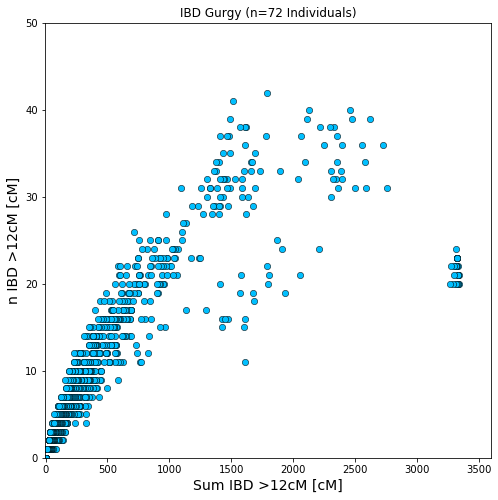

In [70]:
plot_scatter_ibd(df_ibds=df_ibd, savepath="./git/ibd_gurgy/figs/ibd72_v0_scatter.pdf")

In [69]:
df_ibd[50:100]

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
50,GRG067.A01,GRG058.A01,183.879601,2218.448813,38.0,2218.448813,38.0,2203.817513,37.0,2184.644511,36.0
51,GRG043.A01,GRG096.A01,168.272196,2161.559783,43.0,2130.226473,40.0,2013.757773,32.0,2013.757773,32.0
52,GRG057.A01,GRG011.A01,174.486299,2141.878991,42.0,2108.458784,39.0,2066.782287,36.0,1971.056292,31.0
53,GRG029.A01,GRG036.A01,166.134800,2107.125406,35.0,2097.945606,34.0,2097.945606,34.0,2081.874405,33.0
54,GRG029.A01,GRG090.A01,211.111307,2075.628016,36.0,2039.654914,32.0,2010.894715,30.0,1994.341114,29.0
55,GRG037.A01,GRG078.A01,239.171192,2070.443891,38.0,2058.766690,37.0,2030.388686,35.0,1923.798393,29.0
56,GRG107.A01,GRG039.A01,283.652203,2057.168697,21.0,2057.168697,21.0,2057.168697,21.0,2057.168697,21.0
57,GRG025.A01,GRG078.A01,273.202388,1940.393597,20.0,1931.060195,19.0,1931.060195,19.0,1931.060195,19.0
58,GRG041.A01,GRG014.A01,191.577004,1921.103389,25.0,1909.387595,24.0,1909.387595,24.0,1909.387595,24.0
59,GRG068.A01,GRG034.A01,195.195499,1901.131661,34.0,1891.557557,33.0,1863.151963,31.0,1825.286860,29.0
